In [1]:
from __future__ import division

from teext_network import (build_segmenter_simple, build_segmenter_upsample, build_segmenter_jet,
                           build_segmenter_jet_2, build_segmenter_jet_preconv, build_segmenter_simple_absurd_res, 
                           preproc_dataset,)
from train_utils import load_dataset, dataset_loc, batch_compute
import theano.tensor as T
from theano import function as tfn
import cPickle as pickle
import numpy as np
import time
import lasagne.layers as ll
from os.path import join
import matplotlib.pyplot as plt
import cv2
import random
import utool as ut
from itertools import product
%matplotlib inline

Couldn't import dot_parser, loading of dot files will not be possible.

+------

<!!! WARNING !!!>
[!custom_layers] WARNING: GPU seems unavailable
<type 'exceptions.ImportError'>: No module named pylearn2.sandbox.cuda_convnet.filter_acts
</!!! WARNING !!!>

L______

Trying /home/zach/envs/thesis/local/lib/python2.7/site-packages/flann-1.8.4-py2.7.egg/pyflann/lib/libflann.so


Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled)
/home/zach/envs/thesis/local/lib/python2.7/site-packages/Theano-0.8.0.dev0-py2.7.egg/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [2]:
model_loc = 'annot_te_128'
dset_loc = 'annot_te_128'
sec = 'valid'

In [3]:

#model_name = 'jet_ep100_lr1e-2_pw_1e2.pkl'
model_name = 'modelsimple.pkl'
model = ut.load_cPkl(join(dataset_loc, "Flukes/patches/%s" % join(model_loc, model_name)))

dset = load_dataset(join(dataset_loc, "Flukes/patches/%s" % dset_loc), normalize_method='zscore')

[util_io] * load_cPkl(u'.../annot_te_128/modelsimple.pkl')
Loading /home/zach/data/Flukes/patches/annot_te_128
[util_io] * load_cPkl(u'.../annot_te_128/meanstd.pkl')
[util_io] * load_cPkl(u'.../annot_te_128/train.pkl')
[util_io] * load_cPkl(u'.../annot_te_128/val.pkl')
[util_io] * load_cPkl(u'.../annot_te_128/test.pkl')
Took 4.04 seconds


In [4]:
X = T.tensor4()


segmenter = build_segmenter_simple()
ll.set_all_param_values(segmenter, model)
#model_outputs = [ll.get_output(intr_layer, X, deterministic=True) for intr_layer in ll.get_all_layers(segmenter)]
segmenter_out = ll.get_output(segmenter[-1], X, deterministic=True)
segmenter_fn = tfn([X], segmenter_out)

dset_for_model = {section:preproc_dataset(dset[section]) for section in ['train', 'valid', 'test']}

point_outputs = {sec:batch_compute(dset_for_model[sec]['X'], segmenter_fn, 16) for sec in ['train','valid','test']}

In [5]:
list(enumerate(zip([(np.linalg.norm(i), i.shape) for i in 
                    ll.get_all_param_values(segmenter)],ll.get_all_params(segmenter))))

[(0, ((3.3744078, (32, 1, 7, 7)), conv1.W)),
 (1, ((0.90839607, (32,)), conv1.b)),
 (2, ((3.3475835, (64, 32, 5, 5)), conv2.W)),
 (3, ((0.84114224, (64,)), conv2.b)),
 (4, ((2.967087, (128, 64, 5, 5)), conv3.W)),
 (5, ((0.89193386, (128,)), conv3.b)),
 (6, ((2.629283, (64, 128, 5, 5)), conv4.W)),
 (7, ((0.96667808, (64,)), conv4.b)),
 (8, ((2.3186836, (32, 64, 3, 3)), conv5.W)),
 (9, ((1.0199391, (32,)), conv5.b)),
 (10, ((2.2309768, (16, 32, 3, 3)), conv6.W)),
 (11, ((0.68691176, (16,)), conv6.b)),
 (12, ((1.991323, (2, 16, 3, 3)), conv_final.W)),
 (13, ((0.05214075, (2,)), conv_final.b))]

In [6]:
[(ind, i.shape[1:], np.average(np.std(i,axis=0)), l.name) for (ind, i), l in 
 zip(enumerate(point_outputs['valid']),ll.get_all_layers(segmenter))]

[(0, (128, 128), 0.49647257, 'input'),
 (1, (128, 128), 0.49901593, 'conv1'),
 (2, (128, 128), 0.49762917, 'conv2'),
 (3, (128, 128), 0.49692935, 'conv3'),
 (4, (128, 128), 0.49752486, 'conv4'),
 (5, (128, 128), 0.49640578, 'conv5'),
 (6, (128, 128), 0.49426734, 'conv6'),
 (7, (128, 128), 0.49670058, 'conv_final'),
 (8, (128, 128), 0.49656007, '4dsoftmax')]

In [7]:
print(np.average(point_outputs['valid'],axis=0))

[[[ 0.04615616  0.01782625  0.01441406 ...,  0.01832013  0.02471745
    0.05243436]
  [ 0.0191758   0.00989296  0.01091479 ...,  0.01136484  0.01331928
    0.02169746]
  [ 0.0102059   0.00613874  0.00674177 ...,  0.00761459  0.00731977
    0.01094734]
  ..., 
  [ 0.00535164  0.00483235  0.00375358 ...,  0.00130142  0.0010421
    0.00295254]
  [ 0.00827546  0.00665373  0.00607525 ...,  0.00320888  0.00265387
    0.00602738]
  [ 0.02501767  0.00733211  0.00596444 ...,  0.00627079  0.00742772
    0.02079257]]

 [[ 0.95384371  0.98217356  0.98558694 ...,  0.98167926  0.97528327
    0.94756562]
  [ 0.98082483  0.99010664  0.98908436 ...,  0.988635    0.98668021
    0.97830224]
  [ 0.98979425  0.99386001  0.99325722 ...,  0.99238437  0.99267977
    0.98905134]
  ..., 
  [ 0.99464834  0.99517047  0.9962492  ...,  0.99870169  0.9989599
    0.99704641]
  [ 0.99172473  0.99334586  0.99392462 ...,  0.99679059  0.99734598
    0.99397188]
  [ 0.97498202  0.99266797  0.99403596 ...,  0.99372935  0.9

0.499676
0.0565397


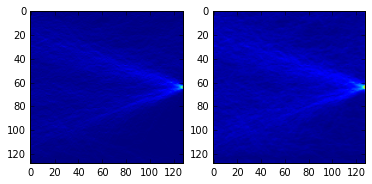

In [8]:
avg_label = np.average(dset_for_model[sec]['y'],axis=0)
avg_pred = np.average(point_outputs[sec],axis=0)
f, ax = plt.subplots(1, 2)
ax[0].imshow(avg_label[0,:,:])
ax[1].imshow(avg_pred[0,:,:])

print(np.average(np.std(point_outputs[sec][-1],axis=0)))
print(np.average(np.std(dset_for_model[sec]['y'],axis=0)))

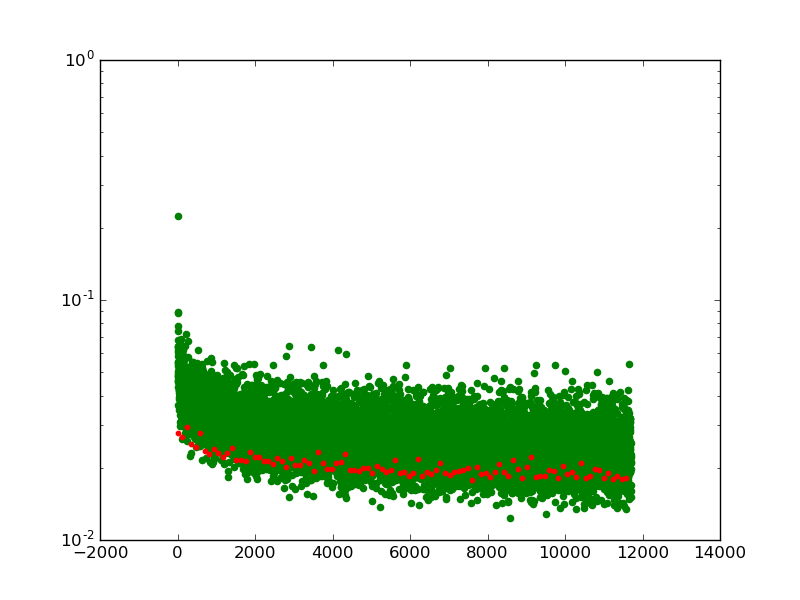

In [9]:
from IPython.display import Image 
Image(filename='./losses.png')

(533, 832)
(528, 832)
(1, 2, 528, 832)


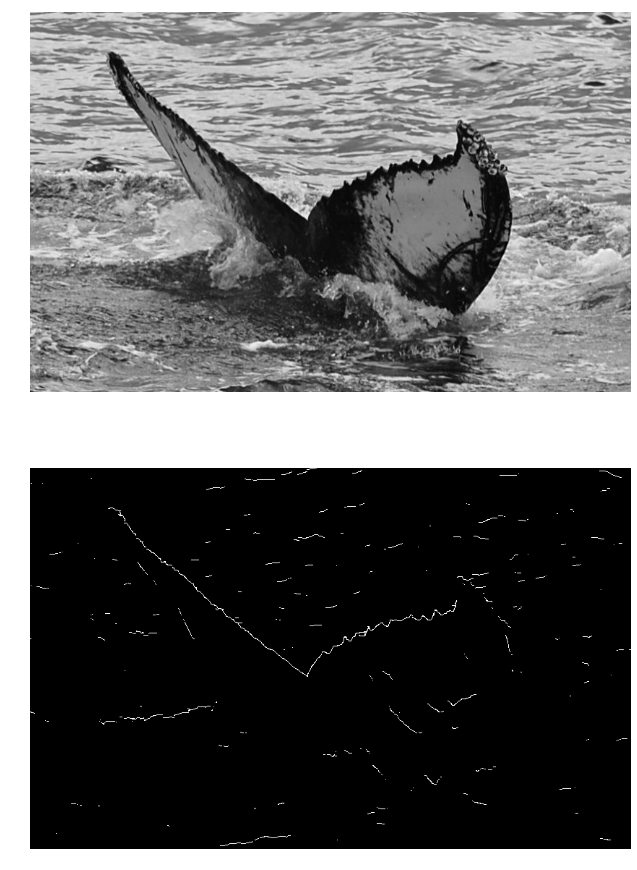

In [10]:
# Let's visualize a random image
def make_acceptable_shape(acceptable_mult, shape):
    new_shape = []
    for shp in shape:
        if shp % acceptable_mult != 0:
            rem = shp % acceptable_mult
            new_shp = shp - rem
            assert(new_shp != 0 and new_shp % acceptable_mult == 0)
            new_shape.append(new_shp)
        else:
            new_shape.append(shp)
    return tuple(new_shape)

imgs_dir = join(dataset_loc, 'Flukes/Flukebook/images')
import glob
zsl_imgs = glob.glob(join(imgs_dir, '*'))
rand_img = cv2.cvtColor(cv2.imread(random.choice(zsl_imgs)),cv2.COLOR_BGR2GRAY)
#rand_img = cv2.equalizeHist(rand_img)
rand_img_res = cv2.resize(rand_img, make_acceptable_shape(8,rand_img.shape)[::-1], cv2.INTER_LANCZOS4)
rand_img_res = (rand_img_res.astype(np.float32) - dset['mean']) / dset['std']
#test_img = np.random.rand(*test_shape).astype(np.float32)
print(rand_img.shape)
print(rand_img_res.shape)
output_img = segmenter_fn(rand_img_res[np.newaxis,np.newaxis,:,:])
print(output_img.shape)
#print(rand_img.shape)
f, ax = plt.subplots(2, figsize=(15,15))
[i.axis('off') for i in ax]
plt.gray()
ax[0].imshow(rand_img_res)
ax[1].imshow(output_img[0,0,:,:] > 0.5)


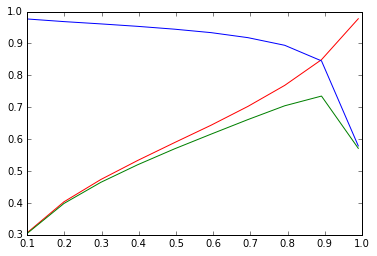

In [11]:
# false positive rate
def precision_recall(true, pred, pos_thresh=0.5):
    # given a set of predicted labels and true labels, figure out what the rate of false positive to true
    # positives is
    # assume decision axis is axis 1
    thresh = lambda x: x[:,0,:,:] > pos_thresh # this makes sense
    thresh_true = thresh(true)
    thresh_pred = thresh(pred)
    # now it's 0 where there's bg, and 1 where there's te
    # if we subtract true from pred, we'll have -1 for a false neg and 1 for a false pos
    n_tp = np.sum(np.logical_and(thresh_true, thresh_pred))
    n_tn = np.sum(1 - np.logical_and(thresh_true, thresh_pred))
    n_fp = np.sum((thresh_pred.astype(np.int) - thresh_true.astype(np.int)) > 0)
    n_fn = np.sum((thresh_pred.astype(np.int) - thresh_true.astype(np.int)) < 0)
    precision = (n_tp) / (n_tp + n_fp)
    recall = (n_tp) / (n_fn + n_tp)
    iou = (n_tp) / (n_tp + n_fn + n_fp)
    return precision, recall, iou

thresholds = np.linspace(0.1,.99,10)
pr_curve = [precision_recall(dset_for_model[sec]['y'], point_outputs[sec], pos_thresh=i) for i in thresholds]
plt.plot(thresholds, zip(*pr_curve)[0], color='r')
plt.plot(thresholds, zip(*pr_curve)[1], color='b')
plt.plot(thresholds, zip(*pr_curve)[2], color='g')

In [12]:
# make it formatted for latex
latex_all = []
for sec in ['train', 'valid', 'test']:
    pr, re, iou = precision_recall(dset_for_model[sec]['y'], point_outputs[sec])
    for i in [pr, re, iou]:
        latex_all.append('%0.2f' % i)
print(' & '.join(latex_all))

0.59 & 0.95 & 0.57 & 0.59 & 0.94 & 0.57 & 0.60 & 0.95 & 0.59


In [13]:
np.sum(np.argmax(dset_for_model[sec]['y'],axis=1) == np.argmax(point_outputs[sec],axis=1)) / np.product(dset_for_model[sec]['y'][:,0,:,:].shape)

0.9969839949986925

### Write model to lev's public model serv

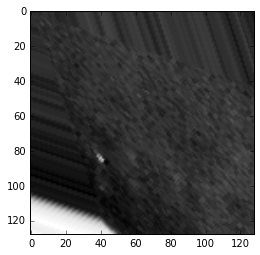

In [14]:
M = np.eye(3, dtype=np.float32)[:-1,:] + 0.5
test_img = dset['std']*dset_for_model[sec]['X'][0][0] + dset['mean']
plt.imshow(cv2.warpAffine(test_img, M, (128,128), 0, 0, cv2.BORDER_REPLICATE))

In [15]:
dset_for_model[sec]['X'][0][0]

array([[-1.13613462, -1.19406748, -1.1071682 , ..., -1.49821532,
        -1.42579913, -1.3099333 ],
       [-1.04923522, -1.1071682 , -1.06371844, ..., -1.49821532,
        -1.49821532, -1.3099333 ],
       [-1.04923522, -1.00578558, -1.0202688 , ..., -1.36786628,
        -1.36786628, -1.3099333 ],
       ..., 
       [ 0.90600038,  0.8915171 ,  0.90600038, ..., -0.7885372 ,
        -0.7450875 , -0.77405393],
       [ 0.90600038,  0.84806746,  0.87703389, ..., -0.68715459,
        -0.60025525, -0.54232234],
       [ 0.96393329,  0.8915171 ,  0.90600038, ..., -0.68715459,
        -0.65818816, -0.61473846]], dtype=float32)

In [16]:
sample_aug = ut.load_cPkl(join(dataset_loc, 'Flukes/patches/sample_aug.pkl'))

[util_io] * load_cPkl(u'.../patches/sample_aug.pkl')


[!plotttool] WARNING guitool does not have __PYQT__
ggplot_style = RcParams({u'axes.axisbelow': True,
          u'axes.edgecolor': u'white',
          u'axes.facecolor': u'#E5E5E5',
          u'axes.grid': True,
          u'axes.labelcolor': u'#555555',
          u'axes.labelsize': u'large',
          u'axes.linewidth': 1.0,
          u'axes.prop_cycle': cycler(u'color', [u'#E24A33', u'#348ABD', u'#988ED5', u'#777777', u'#FBC15E', u'#8EBA42', u'#FFB5B8']),
          u'axes.titlesize': u'x-large',
          u'figure.edgecolor': u'0.50',
          u'figure.facecolor': u'white',
          u'font.size': 10.0,
          u'grid.color': u'white',
          u'grid.linestyle': u'-',
          u'patch.antialiased': True,
          u'patch.edgecolor': u'#EEEEEE',
          u'patch.facecolor': u'#348ABD',
          u'patch.linewidth': 0.5,
          u'xtick.color': u'#555555',
          u'xtick.direction': u'out',
          u'ytick.color': u'#555555',
          u'ytick.direction': u'out'})


/home/zach/envs/thesis/local/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

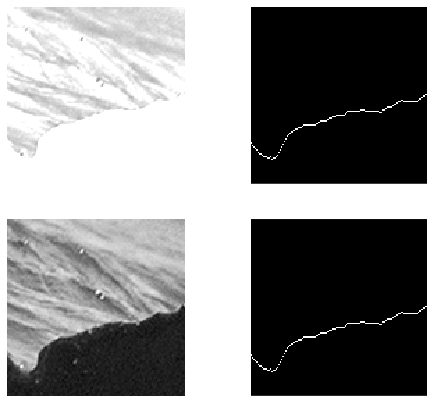

In [17]:
import plottool as pt
rand_ind = np.random.randint(sample_aug[0].shape[0])
pt.gcf().set_size_inches((8,8))
pt.imshow(sample_aug[2][rand_ind][0]*dset['std'] + dset['mean'], pnum=221)
pt.imshow(sample_aug[3][rand_ind][0]*255, pnum=222, interpolation='none')
pt.imshow(sample_aug[0][rand_ind][0]*dset['std'] + dset['mean'], pnum=223)
pt.imshow(sample_aug[1][rand_ind][0]*255, pnum=224, interpolation='none')
(sample_aug[3][rand_ind][0]*255)